In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
# K.set_image_dim_ordering('th')

Using TensorFlow backend.


# Preprocessing

Let's load data from 6 different classes : cat, sheep, giraffe, bat, octopus and camel. Each drawing consists in 784 pixels, and each dataset has between 123 000 and 150 000 drawings.

In [2]:
# load the data
cat = np.load('data/cat.npy')
sheep = np.load('data/sheep.npy')
giraffe = np.load('data/giraffe.npy')
bat = np.load('data/bat.npy')
octopus = np.load('data/octopus.npy')
camel = np.load('data/camel.npy')

print(cat.shape)
print(sheep.shape)
print(giraffe.shape)
print(bat.shape)
print(octopus.shape)
print(camel.shape)

(123202, 784)
(126121, 784)
(127182, 784)
(118114, 784)
(150152, 784)
(121399, 784)


For each class, we add a column to set the labels. { 0:'cat', 1:'giraffe', 2:'sheep', 3:'bat', 4:'octopus', 5:'camel'}



In [3]:
# Each class add one column for label 0, 1, 2, 3, 4, 5

cat = np.c_[cat, np.zeros(len(cat))]
giraffe = np.c_[giraffe, np.ones(len(giraffe))]
sheep = np.c_[sheep, 2*np.ones(len(sheep))]
bat = np.c_[bat, 3*np.ones(len(bat))]
octopus = np.c_[octopus, 4*np.ones(len(octopus))]
camel = np.c_[camel, 5*np.ones(len(camel))]
print(cat.shape)

(123202, 785)


In [4]:
np.c_?

Type:        CClass
String form: <numpy.lib.index_tricks.CClass object at 0x7f77a9db9550>
Length:      0
File:        /opt/conda/lib/python3.7/site-packages/numpy/lib/index_tricks.py
Docstring:  
Translates slice objects to concatenation along the second axis.

This is short-hand for ``np.r_['-1,2,0', index expression]``, which is
useful because of its common occurrence. In particular, arrays will be
stacked along their last axis after being upgraded to at least 2-D with
1's post-pended to the shape (column vectors made out of 1-D arrays).

See Also
--------
column_stack : Stack 1-D arrays as columns into a 2-D array.
r_ : For more detailed documentation.

Examples
--------
>>> np.c_[np.array([1,2,3]), np.array([4,5,6])]
array([[1, 4],
       [2, 5],
       [3, 6]])
>>> np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
array([[1, 2, 3, ..., 4, 5, 6]])


In [5]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

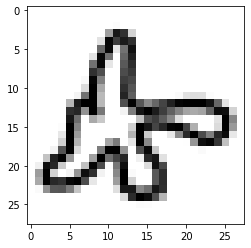

In [6]:
# reshape from 784 to 28:28

plt.imshow(octopus[0,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')

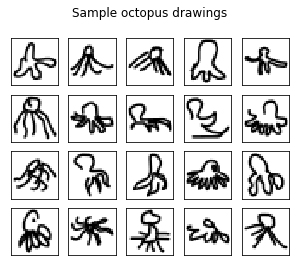

In [7]:
plot_samples(octopus, title='Sample octopus drawings\n')

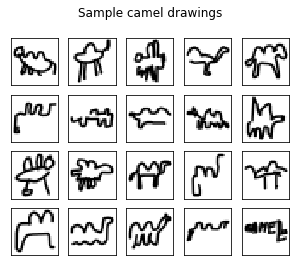

In [8]:
plot_samples(camel, title='Sample camel drawings\n')

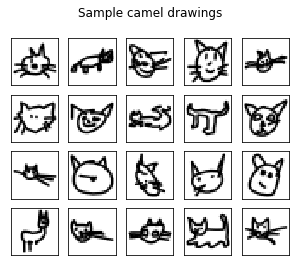

In [9]:
plot_samples(cat, title='Sample camel drawings\n')

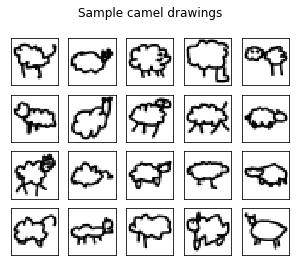

In [10]:
plot_samples(sheep, title='Sample camel drawings\n')


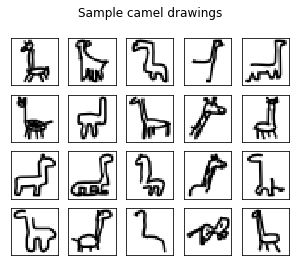

In [11]:
plot_samples(giraffe, title='Sample camel drawings\n')

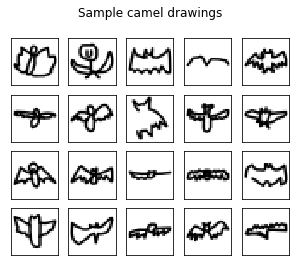

In [12]:
plot_samples(bat, title='Sample camel drawings\n')

Next step :

- We need to combine our data so we can use it for the train and test. I will only use 10 000 samples for this model.
- We then can split the features and labels (X and y).
- Finally, we split data between train and test following the usual (80 - 20) ratio. We also normalize values between 0 and 1 (X/255) as pixels values are initially gray scale between 0 and 255.

In [13]:
# Merging arrays and splitting the features and labels
X = np.concatenate((cat[:10000,:-1], giraffe[:10000,:-1], sheep[:10000,:-1], bat[:10000,:-1], octopus[:10000,:-1], camel[:10000, :-1]), axis=0).astype('float32') # all columns but the last
y = np.concatenate((cat[:10000,-1], giraffe[:10000,-1], sheep[:10000,-1], bat[:10000,-1], octopus[:10000,-1],  camel[:10000,-1]), axis=0).astype('float32') # the last column

# We than split data between train and test (80 - 20 usual ratio). Normalizing the value between 0 and 1
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.2,random_state=0)

In [14]:
y_train

array([0., 0., 5., ..., 4., 4., 0.], dtype=float32)

Output variable is an integer from 0 to 5 (MultiClass Classification problem). We are gonna use a one hot encoding of the class values.

In [15]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

In [16]:
y_train_cnn

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [17]:
# reshape to be [samples][channels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [18]:
X_train_cnn.shape

(48000, 28, 28, 1)

## CNN Model

We will now to build our CNN model using Keras. This model will have the following layers :

- Convolutional Layer : 30 filters, (3 * 3) kernel size
- Max Pooling Layer : (2 * 2) pool size
- Convolutional Layer : 15 filters, (3 * 3) kernel size
- Max Pooling Layer : (2 * 2) pool size
- DropOut Layer : Dropping 20% of neurons.
- Flatten Layer
- Dense/Fully Connected Layer : 128 Neurons, Relu activation function
- Dense/Fully Connected Layer : 50 Neurons, Softmax activation function
- Input shape : pixels width height : 1 28 28

We run our model for 15 epochs and with a batch size of 200.

In [19]:
def cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (3, 3), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
%%time
np.random.seed(0)
# build the model
model_cnn = cnn_model()
# Fit the model
model_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=15, batch_size=200)
# Final evaluation of the model
scores = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 6s 118us/step - loss: 0.7998 - accuracy: 0.7141 - val_loss: 0.4597 - val_accuracy: 0.8465
Epoch 2/15
48000/48000 [==============================] - 1s 26us/step - loss: 0.4548 - accuracy: 0.8497 - val_loss: 0.3547 - val_accuracy: 0.8865
Epoch 3/15
48000/48000 [==============================] - 1s 25us/step - loss: 0.3709 - accuracy: 0.8780 - val_loss: 0.3204 - val_accuracy: 0.8972
Epoch 4/15
48000/48000 [==============================] - 1s 26us/step - loss: 0.3297 - accuracy: 0.8903 - val_loss: 0.2925 - val_accuracy: 0.9082
Epoch 5/15
48000/48000 [==============================] - 1s 26us/step - loss: 0.3009 - accuracy: 0.9013 - val_loss: 0.2712 - val_accuracy: 0.9144
Epoch 6/15
48000/48000 [==============================] - 1s 26us/step - loss: 0.2824 - accuracy: 0.9055 - val_loss: 0.2645 - val_accuracy: 0.9161
Epoch 7/15
48000/48000 [==============================] - 1s 26us/s

# Confusion Matrix

In [21]:
y_pred_cnn = model_cnn.predict_classes(X_test_cnn, verbose=0)

In [22]:
y_pred_cnn

array([0, 1, 5, ..., 5, 2, 1])

In [23]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test, y_pred_cnn)

In [24]:
c_matrix

array([[1838,   19,   40,   45,   21,   20],
       [  27, 1935,    5,   12,    9,   26],
       [  45,    3, 1845,   29,   13,   65],
       [  86,   35,   35, 1767,   28,   85],
       [  28,    7,   17,   25, 1921,   15],
       [  14,   37,   31,   37,   16, 1819]])

In [25]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

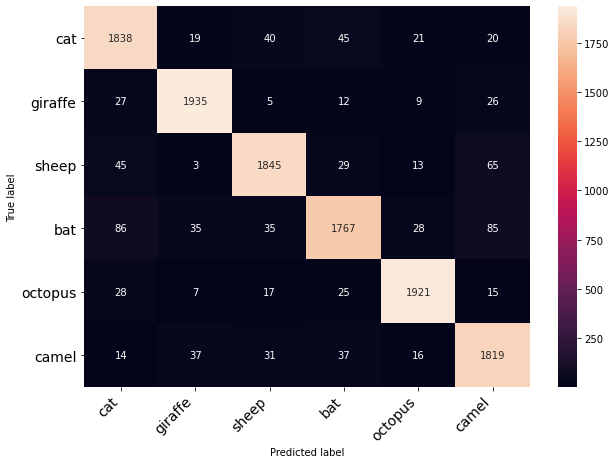

In [26]:
class_names = ['cat', 'giraffe', 'sheep', 'bat', 'octopus', 'camel']
confusion_matrix(c_matrix, class_names, figsize = (10,7), fontsize=14)

In [27]:
#Misclassification when y_pred and y_test are different.
misclassified = X_test[y_pred_cnn != y_test]

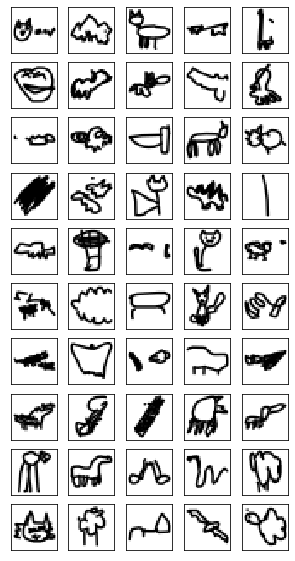

In [28]:
plot_samples(misclassified, rows=10, cols=5, title='')

In [29]:
import pickle
with open('model_cnn.pkl', 'wb') as file:
      pickle.dump(model_cnn, file)

In [31]:
scores = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)

In [50]:
test = X_test_cnn[0].reshape(1, 28, 28, 1)

In [51]:
prediction = model_cnn.predict(test)

In [41]:
index = np.argmax(prediction[0])
label_dict = {0:'Cat', 1:'Giraffe', 2:'Sheep', 3:'Bat', 4:'Octopus', 5:'Camel'}
final_pred = label_dict[index]

In [42]:
final_pred

'Cat'

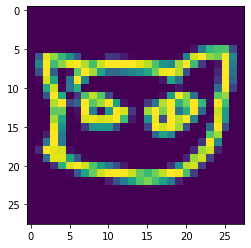

In [45]:
plt.imshow(X_test_cnn[0].squeeze())

In [54]:
model_cnn.save('model_cnn.h5')

In [57]:
model = tf.keras.models.load_model('model_cnn.h5')

In [58]:
model.predict(test)

array([[9.8137671e-01, 3.7681319e-05, 4.5966292e-03, 1.0410761e-02,
        2.2904887e-03, 1.2877305e-03]], dtype=float32)